In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from activ.pipeline import score_clusters
import matplotlib.pyplot as plt
import scipy
import h5py
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as _sch
from collections import Counter
from activ import load_data
import pandas as pd
from math import ceil
import pandas as pd
from matplotlib import cm

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
fulldata = pd.read_csv('/Users/ahyeon/Desktop/TBIanalysis/data/preprocessed_data_matrix.csv', encoding = "ISO-8859-1")
fulldata = fulldata.fillna(-1)
fulldata.shape

(586, 919)

In [3]:
data = load_data()
nmfdata = load_data(uoinmf=True)
oc_features = data.outcome_features
oc_bases = nmfdata.outcome_bases
oc = data.outcomes
oc.shape

(247, 177)

In [4]:
file = '/Users/ahyeon/Desktop/activ misc/sweep_u2-10_c2-50_i50_raw-oc-cluster_uoinmf-bm-predict/umap_clustering_sweep.h5'

In [5]:
f = h5py.File(file, 'r')

In [6]:
umap_dims = f['umap_dimensions'][:]
score = f['score'][:]
norm_score = f['norm_score'][:]
clusters = f['clusters'][:]
cluster_sizes = f['cluster_sizes'][:]
emb = f['umap_embeddings'][:]
scale = f['umap_embeddings_dimscale'][:][:54]

In [7]:
for dim in umap_dims:
    all_dmat = np.zeros((30381,50))
    for x in range(emb.shape[0]):
        dmat = pdist(emb[x][:,scale==dim], metric='mahalanobis')
        all_dmat[:,x] = dmat
    mean = all_dmat.mean(axis=1)
mean.shape

(30381,)

In [8]:
def calc_entropy(gose_scores):
    probs = np.array(list(Counter(gose_scores).values()))/len(gose_scores)
    return entropy(probs, base=2.0)

In [9]:
def entropy_across_clusters(cluster_sizes, data):
    values = []
    tree = _sch.linkage(mean, method='ward')
    labels = _sch.cut_tree(tree, cluster_sizes)
    for ii,c in enumerate(cluster_sizes):
        entropies = []
        for label in np.unique(labels[:,ii]):
            scores = data[labels[:,ii]==label]
            ent = calc_entropy(scores)
            entropies.append(ent)
        v = np.mean(entropies)
        values.append(v)
    return values

In [10]:
# leverage scores
leveragescores = pd.read_csv('/Users/ahyeon/Desktop/activ misc/fullfeaturestable.csv', encoding = "ISO-8859-1")
scores = leveragescores['Leverage Score']
leveragescores
features = leveragescores['0%']

0 NeuroCognitiveDiffRemembering6mo
1 NeuroPhysVisualProbl6mo
2 CHARTSFPhysicalTotal_6mo
3 GOSE_OtherIssues3M
4 NeuroEmotionalSadness6mo
5 GOSE_Reponder6M_Patient.alone
6 NeuroSleepSleepingLess6mo
7 NeuroEmotionalIrritability6mo
8 NeuroSleepTroubleFallingAsleep6mo
9 GOSE_OtherIssues6M


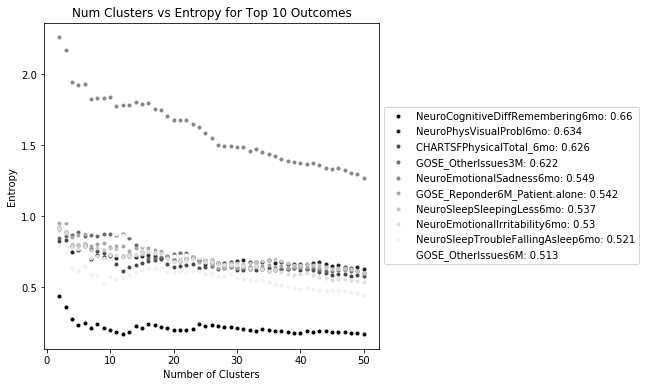

In [56]:
# top 10
plt.figure(figsize=(6,6))
colormap = cm.Greys_r
colors = [colormap(i) for i in np.linspace(0, 1, 10)]
for ii,i in enumerate(features[:10]):
    print(ii,i)
    data = oc[:,ii]
    score = float(round(scores[ii],3))
    plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, data), '.', label=i+ ': ' + str(score), color=colors[ii])
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Entropy')
    plt.title('Num Clusters vs Entropy for Top 10 Outcomes')
plt.savefig('/Users/ahyeon/Desktop/activ misc/top10_entropy.pdf',bbox_inches='tight')

In [57]:
plt.figure(figsize=(6,6))
colormap = cm.Greys_r
colors = [colormap(i) for i in np.linspace(0, 1, 10)]
new_data = []
for ii,i in enumerate(features[:10]):
    data = oc[:,ii]
    new_data.append(data)

# plt.savefig('/Users/ahyeon/Desktop/activ misc/top10_entropy.pdf',bbox_inches='tight')

<Figure size 432x432 with 0 Axes>

In [58]:
new_data[0]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,
        1.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [59]:
new_data2 = new_data[::-1]

In [60]:
new_data2[0]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
        1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,
        1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,
        0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,
        1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,
        1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1

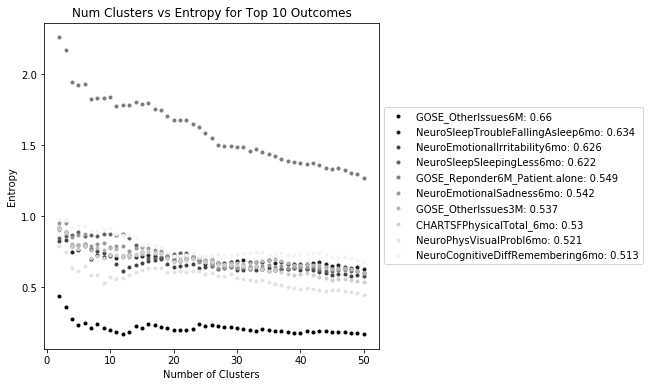

In [70]:
# top 10
plt.figure(figsize=(6,6))
colormap = cm.Greys_r
colors = [colormap(i) for i in np.linspace(0, 0.9, 10)]
for ii,i in enumerate(features[:10]):
    data = oc[:,ii]
    score = float(round(scores[ii],3))
    plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, data), '.', label=i+ ': ' + str(score), color=colors[ii])
    plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Entropy')
    plt.title('Num Clusters vs Entropy for Top 10 Outcomes')
plt.savefig('/Users/ahyeon/Desktop/activ misc/top10_entropy.pdf',bbox_inches='tight')

In [15]:
# norm of each feature
ents = []
for ii,i in enumerate(features[:5]):
    data = oc[:,ii]
    score = float(round(scores[ii],3))
    ent = entropy_across_clusters(cluster_sizes, data)
    max_ent = max(ent)
    norm_es=[]
    for e in ent:
        norm_e = e/max_ent
        norm_es.append(norm_e)
    ents.append(norm_es)


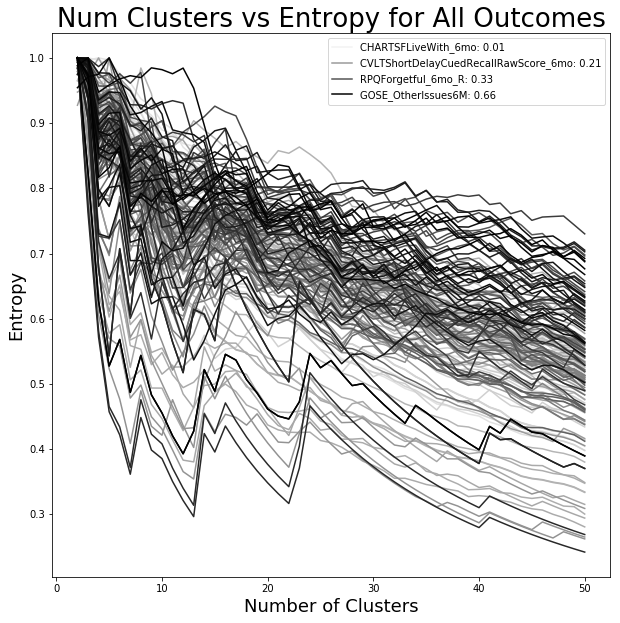

In [13]:
# all features normed

plt.figure(figsize=(10,10))
colormap = cm.Greys_r
colors = [colormap(i) for i in np.linspace(0, 0.9, 177)]
include = [0,50,100,176,177]
features = features[::-1]
index = np.arange(0,177)[::-1]

for x,y in zip(features, index):
    data = oc[:,y]
    score = float(round(scores[y], 3))
    plt.gray()
    plt.plot(cluster_sizes, ents[y], color=colors[y])
    plt.xlabel('Number of Clusters', fontsize=18)
    plt.ylabel('Entropy', fontsize=18)
    plt.title('Num Clusters vs Entropy for All Outcomes', fontsize=26)
    if y in include:
        plt.plot(cluster_sizes, ents[y], color=colors[y], label=x+ ': ' + str(score))
        plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/all_entropy_norm.pdf',bbox_inches='tight')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


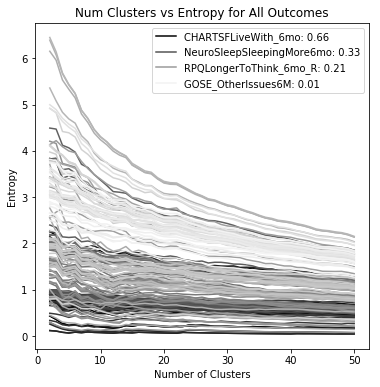

In [38]:
# all features

plt.figure(figsize=(6,6))
colormap = cm.Greys_r
colors = [colormap(i) for i in np.linspace(0, 0.9, 177)]
include = [0,50,100,176,177]
for ii,i in enumerate(features):
    print(ii)
    data = oc[:,ii]
    score = float(round(scores[ii],3))
    plt.gray()
    plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, data), color=colors[ii])
    plt.xlabel('Number of Clusters')
    plt.ylabel('Entropy')
    plt.title('Num Clusters vs Entropy for All Outcomes')
    if ii in include:
        plt.plot(cluster_sizes, entropy_across_clusters(cluster_sizes, data), color=colors[ii], label=i+ ': ' + str(score))
        plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/all_entropy.pdf',bbox_inches='tight')